## Takes each segmented cell from Cell Profiler output dataframe, Matching Pursuit Output image to generate QC file for filtering

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import os
import sys
import glob
import pandas as pd
import xml.etree.ElementTree as et
import datetime
from imageio import volread as imread

import tifffile

# from pystackreg import StackReg --> don't run this, run this with imlab environment
from skimage.filters import threshold_otsu

import seaborn as sns
#from pystackreg.util import to_uint16

from skimage import measure
from scipy import stats
import umap
import scanpy as sc
#from umap.umap_ import UMAP

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
import pickle

In [2]:
# 101222_D10_Coverslip1_Processed
# 102022_D10_Coverslip2_Reimage_Processed
# 101422_D10_Coverslip3_Processed
# 102222_D10_Coverslip4_Reimage_Processed
# 101922_D10_Coverslip5_Processed
print(os.getcwd())
os.chdir('../101222_D10_Coverslip1_Processed')
print(os.getcwd())

/Volumes/imagestore/Brian/src
/Volumes/imagestore/Brian/101222_D10_Coverslip1_Processed


In [3]:
# Load Feature Data
CP_DIR = 'cp_output_cellpose'
MASK_DIR = 'Cellpose_Segmentation_masks' # note: nuclei mask do not match with soma. take caution.
MP_DIR = 'mp_score_max'

DATA_DIR = 'max'
#Compartment = 'Soma_filtered'
DATA_TYPE = 'max'
META_DIR = 'metadata'

_allFOVs = sorted(glob.glob(f'{MP_DIR}/*'))
allFOVs = [x.split('F')[-1][:3] for x in _allFOVs]
len(allFOVs)

225

,channel_number,cycle_number,marker_name,Filter,excitation_wavelength,emission_wavelength,Bandwidth,ch_index,Split_Num
0,1,0,DNA_0,DAPI,405,445,46,0,0
1,2,0,Blank_488_0,GFP,488,521,38,1,1
2,3,0,Blank_561_0,RFP,561,594,43,2,2
3,4,0,Blank_637_0,Cy5,637,698,77,3,3
4,5,1,DNA_1,DAPI,405,445,46,0,4
5,6,1,NWS,GFP,488,521,38,1,5
6,7,1,VSVG,RFP,561,594,43,2,6
7,8,1,FLAG,Cy5,637,698,77,3,7
8,9,2,DNA_2,DAPI,405,445,46,0,8
9,10,2,HSV,GFP,488,521,38,1,9


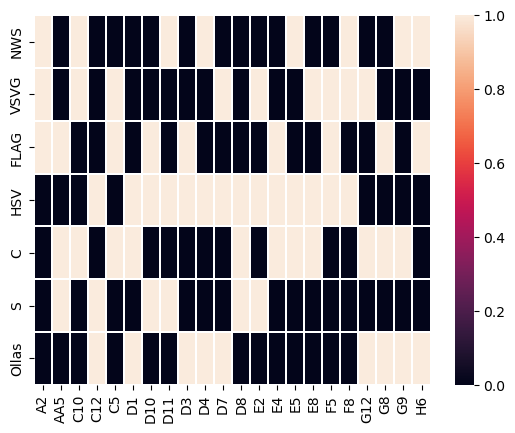

In [4]:
# load metadata - load full codebook as well
full_codebook = pd.read_csv(f'../{META_DIR}/full_codebook.csv',sep=',', index_col=0) # this is "legal" codebook
Procode_gRNA = pd.read_csv(f'../{META_DIR}/PROCODE_gRNA.csv',sep=',')
legal_codes = sorted(list(set(Procode_gRNA['ProCode ID'].to_list())))
codebook = full_codebook[legal_codes]
#AllProcodes = pd.read_csv('AllProcodes.csv', sep='.')
sns.heatmap(codebook, linewidths = 0.3)
markers = pd.read_csv(f'../{META_DIR}/markers.csv')
markers.head(50)

In [5]:
def get_cell_coords(cell_label, coord_data):
    
    x2 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMaximum_X']
    y2 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMaximum_Y']
    x1 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMinimum_X']
    y1 = coord_data.loc[cell_label, 'AreaShape_BoundingBoxMinimum_Y']
    
    return round(x1),round(x2),round(y1),round(y2)

def Calculate_PCA_Loadings(X):
    
    pca = PCA(random_state=1)
    PCs = pca.fit_transform(X)
    exp_var_pca = pca.explained_variance_ratio_ # only visualize top 10 PCs
    
    ratio = exp_var_pca[0]/(exp_var_pca[1]+1e-15) # PC1/PC2
    if math.isnan(ratio): 
        ratio = 1
    #
    return exp_var_pca[0], exp_var_pca[1], exp_var_pca[2], ratio # %var of PC1, PC2, PC3, ratio 

(22, 2015, 2018)


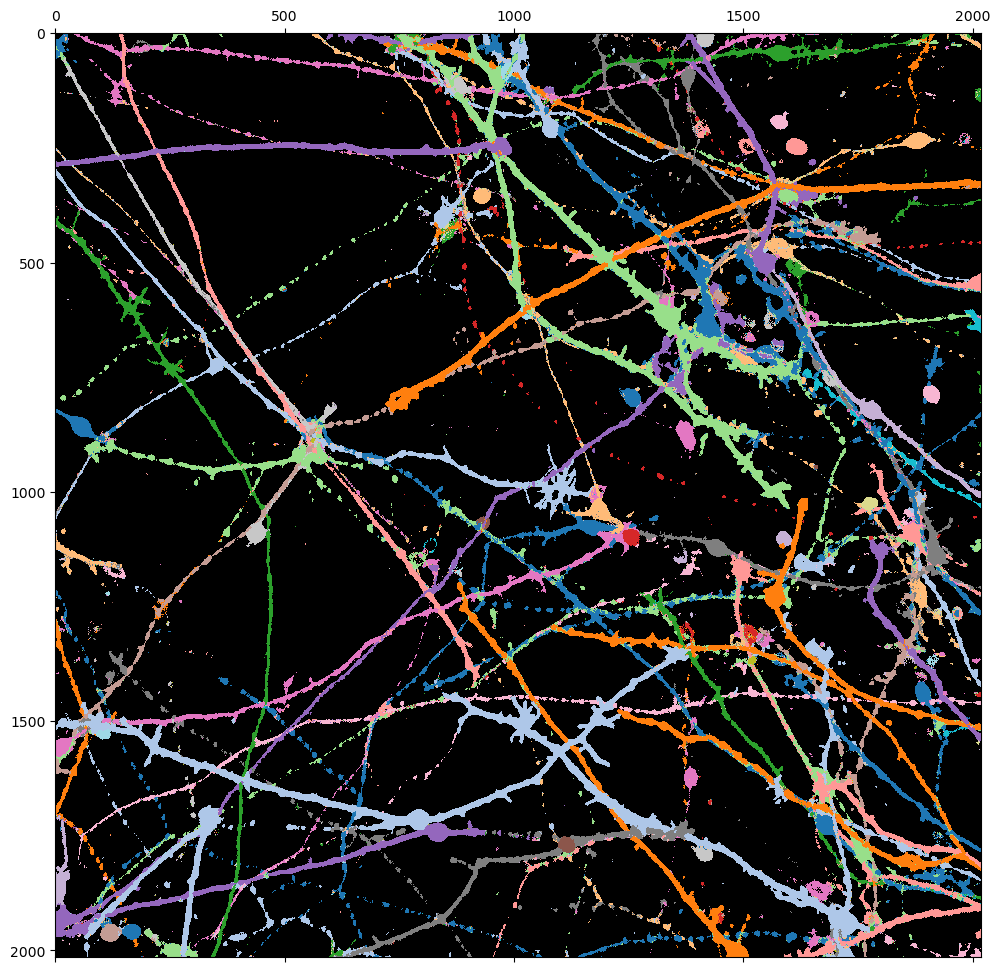

In [6]:
fov = '125'
mpscore = imread(f'{MP_DIR}/F{fov}_mp_score_max.tif')
print(mpscore.shape)
cm = plt.get_cmap('tab20')
cm.set_bad('k')
plt.figure(figsize=(12,12))
plt.gca().matshow(np.where(mpscore.max(0)==0, np.nan, mpscore.argmax(0)),cmap=cm)

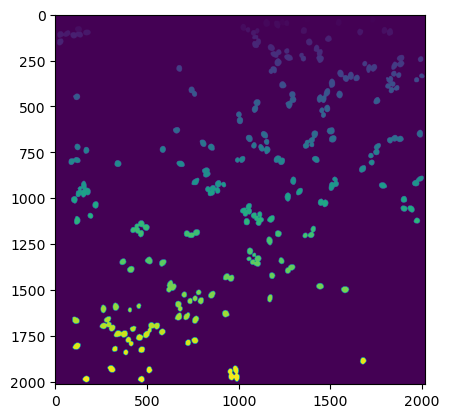

In [8]:
fov='000'
soma = imread(f'{MASK_DIR}/F{fov}_{DATA_TYPE}_Soma.tiff')
plt.imshow(soma)

In [20]:
## load cp_df
cp_df = pd.read_csv(f'{CP_DIR}/CP_Cellpose_Soma_filtered_32.csv', index_col=0)
print(cp_df.shape)
print(cp_df.loc[0,'PathName_max'])

(111515, 4248)
/media/imaging/Expansion/101222_D10_Coverslip1_Processed/max


In [21]:
## Assign Gene ID
procode_gene_df = pd.read_csv('../metadata/PROCODE_gRNA.csv')
procode_to_gene = {}
for cell in procode_gene_df.index:
    procode = procode_gene_df.loc[cell,'ProCode ID']
    if procode not in procode_to_gene.keys():
        procode_to_gene[procode] = procode_gene_df.loc[cell,'Gene Target']
        
for fov in allFOVs:
    print("Reading...", f'{MASK_DIR}/F{fov}_{DATA_TYPE}_Soma.tiff')
    soma = imread(f'{MASK_DIR}/F{fov}_{DATA_TYPE}_Soma.tiff') # mask image
    
    mpscore = imread(f'{MP_DIR}/F{fov}_mp_score_max.tif').transpose(1,2,0) # 22 barcode channels # YXC
    seg = imread(f'{DATA_TYPE}/F{fov}_{DATA_TYPE}.tif') # 25, 2015X2018 
    # max, take first 1:8 channels to calculate epitope tag intensity
    x_norm = np.linalg.norm(seg[1:8], axis=0, ord=2) # calculate x_norm for overall signal intensity
    
    # scores_df is the probs_df (Cell By MP Score)
    scores = measure.regionprops_table(soma, mpscore, properties = ['label','intensity_mean'])
    scores_df = pd.DataFrame(scores)
    scores_df = scores_df.set_index('label')
    barcode_cols = scores_df.columns.tolist() # intensity_mean-0 is first codebook column
    
    # create x_norm measurements
    x_norm_measure = measure.regionprops_table(soma, x_norm, properties = ['label','intensity_mean'])
    x_norm_df = pd.DataFrame(x_norm_measure)
    x_norm_df = x_norm_df.set_index('label')
    
    # assign barcode with max mean score
    barcoded = pd.DataFrame(index = scores_df.index) # indexed using cell labels 1,2,3...280
    barcode_cols = scores_df.columns.tolist()
    max_col = scores_df[barcode_cols].idxmax(axis=1) # find maximum column name intensity_mean-0, etc
    barcoded['Barcode_Idx'] = max_col # assign intensity_mean-X 
    barcoded['SUM'] = scores_df[barcode_cols].sum(axis=1) # sum of all mpscore signal
    
    for cell in scores_df.index: # index is object number
        idx = barcoded.loc[cell,'Barcode_Idx'] # intensity_mean-0
        procode = codebook.columns.tolist()[int(idx.split('-')[-1])] # extract barcode name from intensity_mean-0
        barcoded.loc[cell, 'Barcode'] = procode
        barcoded.loc[cell, 'RAW'] = scores_df.loc[cell, idx]
    
    ## Calculate P, LOGIT
    barcoded['P'] = barcoded['RAW'] / (barcoded['SUM']+1e-15) # normalized score
    barcoded['LOGIT'] = np.log((barcoded['P']+1e-15)/(1-barcoded['P'] + 1e-15))
    
    ## Calculate Entropy ## vectorize?
    from scipy.stats import entropy
    p=(scores_df.values+1e-15)/(np.reshape(barcoded['SUM'].values, (-1,1))+1e-15)
    barcoded['ENTROPY'] = entropy(p, axis=1)
    
    ## Calculate x_norm dataframe
    barcoded['X_NORM'] = x_norm_df['intensity_mean']
    
    ## assign gene names from barcodes
    for cell in barcoded.index:
        barcode = barcoded.loc[cell, 'Barcode']
        barcoded.loc[cell, 'Gene'] = procode_to_gene[barcode]
    
    image_num = list(set(cp_df[cp_df['FileName_max'] == f'F{fov}_max.tif'].ImageNumber.values))[0]
    barcoded['ImageNumber'] = image_num
    coord_data = cp_df[cp_df.ImageNumber == image_num]
    coord_data = coord_data.set_index("ObjectNumber")
    
    # Add overlap score to barcoded dataframe
    S_cutoffs = [0.1, 0.2, 0.3] # user defined cutoff value
    for S_cutoff in S_cutoffs:
        mpscore_bin = mpscore > S_cutoff
        
        for label in barcoded.index:
            x1,x2,y1,y2 = get_cell_coords(label,coord_data)
            prob_ind = int(barcoded.loc[label, "Barcode_Idx"].split('-')[1])
            soma_bin = soma[y1:y2,x1:x2]==label # create binary soma mask
            overlap_score = (mpscore_bin[y1:y2,x1:x2, prob_ind]&soma_bin).sum()/soma_bin.sum()
            barcoded.loc[label, f"Overlap_{S_cutoff}"] = overlap_score
    
    # Jaccard Index Score and PCA loadings
    for label in barcoded.index:
        # Jaccard Index
        x1,x2,y1,y2 = get_cell_coords(label,coord_data)
        soma_bin = soma[y1:y2,x1:x2]==label
        prob_ind = int(barcoded.loc[label, "Barcode_Idx"].split('-')[1])
        thres = threshold_otsu(mpscore[y1:y2,x1:x2, prob_ind])
        mpscore_bin = mpscore[y1:y2,x1:x2, prob_ind]>thres
        J = (mpscore_bin&soma_bin).sum()/((mpscore_bin|soma_bin).sum()+1e-15) # avoid division by zero
        barcoded.loc[label, "Jaccard"] = J
        
        # PCA loadings
        soma_bin = soma==label
        score = mpscore.transpose(2,0,1) # CYX
        mpscore_masked = np.multiply(soma_bin, score) # C Y X
        X = mpscore_masked[:,y1:y2,x1:x2] 
        X = X.reshape(X.shape[1]*X.shape[2], X.shape[0])
        PC1,PC2,PC3,ratio = Calculate_PCA_Loadings(X)
        barcoded.loc[label, 'PC1_var'] = PC1
        barcoded.loc[label, 'PC2_var'] = PC2
        barcoded.loc[label, 'PC3_var'] = PC3
        barcoded.loc[label, 'PC1/PC2'] = ratio
    
    ## Add epitope mean intensity for UMAP
    epitopes_image = seg[1:8].transpose(1,2,0) # YXC # max_clean
    epitope_measure = measure.regionprops_table(soma, epitopes_image, properties = ['label','intensity_mean'])
    epitope_df = pd.DataFrame(epitope_measure)
    epi_cols = epitope_df.columns[1:]
    barcoded[epi_cols] = epitope_df[epi_cols].values
    #print(barcoded.columns)
    
    ## Calculate Delta
    for label in barcoded.index:
        L = sorted(barcoded.loc[label, epi_cols].values, reverse=True) # sort in descending order
        Delta = L[2] - L[3] # 3rd and 4th 
        barcoded.loc[label, 'Delta'] = Delta
    
    if image_num == 1: # if first image, set soma_df = barcoded itself
        soma_df = barcoded.copy()
    else:
        soma_df = pd.concat([soma_df, barcoded], axis=0)
    print(len(soma_df))
    #print(soma_df)
    print('.................................................')
soma_df

Reading... Cellpose_Segmentation_masks/F000_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

244
.................................................
Reading... Cellpose_Segmentation_masks/F001_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

486
.................................................
Reading... Cellpose_Segmentation_masks/F002_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

721
.................................................
Reading... Cellpose_Segmentation_masks/F003_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

1021
.................................................
Reading... Cellpose_Segmentation_masks/F004_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


1328
.................................................
Reading... Cellpose_Segmentation_masks/F005_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

1601
.................................................
Reading... Cellpose_Segmentation_masks/F006_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

1894
.................................................
Reading... Cellpose_Segmentation_masks/F007_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


2119
.................................................
Reading... Cellpose_Segmentation_masks/F008_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

2380
.................................................
Reading... Cellpose_Segmentation_masks/F009_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

2589
.................................................
Reading... Cellpose_Segmentation_masks/F010_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

2857
.................................................
Reading... Cellpose_Segmentation_masks/F011_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

3106
.................................................
Reading... Cellpose_Segmentation_masks/F012_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

3378
.................................................
Reading... Cellpose_Segmentation_masks/F013_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

3677
.................................................
Reading... Cellpose_Segmentation_masks/F014_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

3996
.................................................
Reading... Cellpose_Segmentation_masks/F015_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

4356
.................................................
Reading... Cellpose_Segmentation_masks/F016_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

4672
.................................................
Reading... Cellpose_Segmentation_masks/F017_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

4969
.................................................
Reading... Cellpose_Segmentation_masks/F018_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

5230
.................................................
Reading... Cellpose_Segmentation_masks/F019_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

5496
.................................................
Reading... Cellpose_Segmentation_masks/F020_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

5752
.................................................
Reading... Cellpose_Segmentation_masks/F021_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

6102
.................................................
Reading... Cellpose_Segmentation_masks/F022_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

6381
.................................................
Reading... Cellpose_Segmentation_masks/F023_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

6722
.................................................
Reading... Cellpose_Segmentation_masks/F024_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

7135
.................................................
Reading... Cellpose_Segmentation_masks/F025_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

7436
.................................................
Reading... Cellpose_Segmentation_masks/F026_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

7774
.................................................
Reading... Cellpose_Segmentation_masks/F027_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

8142
.................................................
Reading... Cellpose_Segmentation_masks/F028_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

8542
.................................................
Reading... Cellpose_Segmentation_masks/F029_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


8882
.................................................
Reading... Cellpose_Segmentation_masks/F030_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

9392
.................................................
Reading... Cellpose_Segmentation_masks/F031_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

9823
.................................................
Reading... Cellpose_Segmentation_masks/F032_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

10220
.................................................
Reading... Cellpose_Segmentation_masks/F033_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

10553
.................................................
Reading... Cellpose_Segmentation_masks/F034_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

10800
.................................................
Reading... Cellpose_Segmentation_masks/F035_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

11152
.................................................
Reading... Cellpose_Segmentation_masks/F036_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

11553
.................................................
Reading... Cellpose_Segmentation_masks/F037_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

12003
.................................................
Reading... Cellpose_Segmentation_masks/F038_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

12607
.................................................
Reading... Cellpose_Segmentation_masks/F039_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

13204
.................................................
Reading... Cellpose_Segmentation_masks/F040_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

13905
.................................................
Reading... Cellpose_Segmentation_masks/F041_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

14603
.................................................
Reading... Cellpose_Segmentation_masks/F042_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

15237
.................................................
Reading... Cellpose_Segmentation_masks/F043_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

15709
.................................................
Reading... Cellpose_Segmentation_masks/F044_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

16155
.................................................
Reading... Cellpose_Segmentation_masks/F045_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

16738
.................................................
Reading... Cellpose_Segmentation_masks/F046_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

17318
.................................................
Reading... Cellpose_Segmentation_masks/F047_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

17982
.................................................
Reading... Cellpose_Segmentation_masks/F048_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

18797
.................................................
Reading... Cellpose_Segmentation_masks/F049_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

19781
.................................................
Reading... Cellpose_Segmentation_masks/F050_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

20226
.................................................
Reading... Cellpose_Segmentation_masks/F051_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

20838
.................................................
Reading... Cellpose_Segmentation_masks/F052_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

21645
.................................................
Reading... Cellpose_Segmentation_masks/F053_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

22575
.................................................
Reading... Cellpose_Segmentation_masks/F054_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

23349
.................................................
Reading... Cellpose_Segmentation_masks/F055_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

24266
.................................................
Reading... Cellpose_Segmentation_masks/F056_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


25163
.................................................
Reading... Cellpose_Segmentation_masks/F057_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

26046
.................................................
Reading... Cellpose_Segmentation_masks/F058_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

26705
.................................................
Reading... Cellpose_Segmentation_masks/F059_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

27220
.................................................
Reading... Cellpose_Segmentation_masks/F060_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

27852
.................................................
Reading... Cellpose_Segmentation_masks/F061_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

28508
.................................................
Reading... Cellpose_Segmentation_masks/F062_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

29416
.................................................
Reading... Cellpose_Segmentation_masks/F063_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

30436
.................................................
Reading... Cellpose_Segmentation_masks/F064_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

31433
.................................................
Reading... Cellpose_Segmentation_masks/F065_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


32578
.................................................
Reading... Cellpose_Segmentation_masks/F066_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

33901
.................................................
Reading... Cellpose_Segmentation_masks/F067_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

35029
.................................................
Reading... Cellpose_Segmentation_masks/F068_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

36079
.................................................
Reading... Cellpose_Segmentation_masks/F069_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

36920
.................................................
Reading... Cellpose_Segmentation_masks/F070_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

38002
.................................................
Reading... Cellpose_Segmentation_masks/F071_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

39370
.................................................
Reading... Cellpose_Segmentation_masks/F072_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

40711
.................................................
Reading... Cellpose_Segmentation_masks/F073_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

41890
.................................................
Reading... Cellpose_Segmentation_masks/F074_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

43094
.................................................
Reading... Cellpose_Segmentation_masks/F075_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

44217
.................................................
Reading... Cellpose_Segmentation_masks/F076_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

45527
.................................................
Reading... Cellpose_Segmentation_masks/F077_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

46813
.................................................
Reading... Cellpose_Segmentation_masks/F078_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


47871
.................................................
Reading... Cellpose_Segmentation_masks/F079_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


49077
.................................................
Reading... Cellpose_Segmentation_masks/F080_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


50038
.................................................
Reading... Cellpose_Segmentation_masks/F081_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

51047
.................................................
Reading... Cellpose_Segmentation_masks/F082_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


52059
.................................................
Reading... Cellpose_Segmentation_masks/F083_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

53004
.................................................
Reading... Cellpose_Segmentation_masks/F084_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


53934
.................................................
Reading... Cellpose_Segmentation_masks/F085_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


54705
.................................................
Reading... Cellpose_Segmentation_masks/F086_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

55392
.................................................
Reading... Cellpose_Segmentation_masks/F087_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

56103
.................................................
Reading... Cellpose_Segmentation_masks/F088_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

56779
.................................................
Reading... Cellpose_Segmentation_masks/F089_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

57593
.................................................
Reading... Cellpose_Segmentation_masks/F090_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


58158
.................................................
Reading... Cellpose_Segmentation_masks/F091_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

58686
.................................................
Reading... Cellpose_Segmentation_masks/F092_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

59298
.................................................
Reading... Cellpose_Segmentation_masks/F093_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

59924
.................................................
Reading... Cellpose_Segmentation_masks/F094_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

60520
.................................................
Reading... Cellpose_Segmentation_masks/F095_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

61082
.................................................
Reading... Cellpose_Segmentation_masks/F096_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

61596
.................................................
Reading... Cellpose_Segmentation_masks/F097_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

62073
.................................................
Reading... Cellpose_Segmentation_masks/F098_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

62514
.................................................
Reading... Cellpose_Segmentation_masks/F099_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

63025
.................................................
Reading... Cellpose_Segmentation_masks/F100_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

63598
.................................................
Reading... Cellpose_Segmentation_masks/F101_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

64223
.................................................
Reading... Cellpose_Segmentation_masks/F102_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

64899
.................................................
Reading... Cellpose_Segmentation_masks/F103_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

65682
.................................................
Reading... Cellpose_Segmentation_masks/F104_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

66584
.................................................
Reading... Cellpose_Segmentation_masks/F105_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

67361
.................................................
Reading... Cellpose_Segmentation_masks/F106_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

68057
.................................................
Reading... Cellpose_Segmentation_masks/F107_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

68759
.................................................
Reading... Cellpose_Segmentation_masks/F108_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


69297
.................................................
Reading... Cellpose_Segmentation_masks/F109_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

69829
.................................................
Reading... Cellpose_Segmentation_masks/F110_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

70363
.................................................
Reading... Cellpose_Segmentation_masks/F111_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

70903
.................................................
Reading... Cellpose_Segmentation_masks/F112_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

71355
.................................................
Reading... Cellpose_Segmentation_masks/F113_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

71983
.................................................
Reading... Cellpose_Segmentation_masks/F114_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

72678
.................................................
Reading... Cellpose_Segmentation_masks/F115_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

73301
.................................................
Reading... Cellpose_Segmentation_masks/F116_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

73899
.................................................
Reading... Cellpose_Segmentation_masks/F117_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

74484
.................................................
Reading... Cellpose_Segmentation_masks/F118_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

74994
.................................................
Reading... Cellpose_Segmentation_masks/F119_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

75440
.................................................
Reading... Cellpose_Segmentation_masks/F120_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


75892
.................................................
Reading... Cellpose_Segmentation_masks/F121_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

76343
.................................................
Reading... Cellpose_Segmentation_masks/F122_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

76831
.................................................
Reading... Cellpose_Segmentation_masks/F123_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

77375
.................................................
Reading... Cellpose_Segmentation_masks/F124_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

77973
.................................................
Reading... Cellpose_Segmentation_masks/F125_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

78202
.................................................
Reading... Cellpose_Segmentation_masks/F126_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

78587
.................................................
Reading... Cellpose_Segmentation_masks/F127_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

78906
.................................................
Reading... Cellpose_Segmentation_masks/F128_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

79370
.................................................
Reading... Cellpose_Segmentation_masks/F129_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

79808
.................................................
Reading... Cellpose_Segmentation_masks/F130_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

80318
.................................................
Reading... Cellpose_Segmentation_masks/F131_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

80739
.................................................
Reading... Cellpose_Segmentation_masks/F132_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

81072
.................................................
Reading... Cellpose_Segmentation_masks/F133_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

81355
.................................................
Reading... Cellpose_Segmentation_masks/F134_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

81725
.................................................
Reading... Cellpose_Segmentation_masks/F135_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

82036
.................................................
Reading... Cellpose_Segmentation_masks/F136_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

82459
.................................................
Reading... Cellpose_Segmentation_masks/F137_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

82866
.................................................
Reading... Cellpose_Segmentation_masks/F138_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

83262
.................................................
Reading... Cellpose_Segmentation_masks/F139_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

83651
.................................................
Reading... Cellpose_Segmentation_masks/F140_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


84036
.................................................
Reading... Cellpose_Segmentation_masks/F141_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

84392
.................................................
Reading... Cellpose_Segmentation_masks/F142_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

84819
.................................................
Reading... Cellpose_Segmentation_masks/F143_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

85173
.................................................
Reading... Cellpose_Segmentation_masks/F144_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

85546
.................................................
Reading... Cellpose_Segmentation_masks/F145_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

85906
.................................................
Reading... Cellpose_Segmentation_masks/F146_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

86301
.................................................
Reading... Cellpose_Segmentation_masks/F147_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

86653
.................................................
Reading... Cellpose_Segmentation_masks/F148_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

87088
.................................................
Reading... Cellpose_Segmentation_masks/F149_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

87494
.................................................
Reading... Cellpose_Segmentation_masks/F150_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

87705
.................................................
Reading... Cellpose_Segmentation_masks/F151_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

88107
.................................................
Reading... Cellpose_Segmentation_masks/F152_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

88454
.................................................
Reading... Cellpose_Segmentation_masks/F153_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

88853
.................................................
Reading... Cellpose_Segmentation_masks/F154_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

89233
.................................................
Reading... Cellpose_Segmentation_masks/F155_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

89525
.................................................
Reading... Cellpose_Segmentation_masks/F156_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

89846
.................................................
Reading... Cellpose_Segmentation_masks/F157_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

90133
.................................................
Reading... Cellpose_Segmentation_masks/F158_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

90437
.................................................
Reading... Cellpose_Segmentation_masks/F159_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

90715
.................................................
Reading... Cellpose_Segmentation_masks/F160_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

91064
.................................................
Reading... Cellpose_Segmentation_masks/F161_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


91317
.................................................
Reading... Cellpose_Segmentation_masks/F162_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

91642
.................................................
Reading... Cellpose_Segmentation_masks/F163_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

91950
.................................................
Reading... Cellpose_Segmentation_masks/F164_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

92267
.................................................
Reading... Cellpose_Segmentation_masks/F165_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

92567
.................................................
Reading... Cellpose_Segmentation_masks/F166_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

92848
.................................................
Reading... Cellpose_Segmentation_masks/F167_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

93146
.................................................
Reading... Cellpose_Segmentation_masks/F168_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

93410
.................................................
Reading... Cellpose_Segmentation_masks/F169_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

93659
.................................................
Reading... Cellpose_Segmentation_masks/F170_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

93867
.................................................
Reading... Cellpose_Segmentation_masks/F171_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

94126
.................................................
Reading... Cellpose_Segmentation_masks/F172_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

94466
.................................................
Reading... Cellpose_Segmentation_masks/F173_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

94709
.................................................
Reading... Cellpose_Segmentation_masks/F174_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

94978
.................................................
Reading... Cellpose_Segmentation_masks/F175_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

95380
.................................................
Reading... Cellpose_Segmentation_masks/F176_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

95878
.................................................
Reading... Cellpose_Segmentation_masks/F177_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

96352
.................................................
Reading... Cellpose_Segmentation_masks/F178_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

96845
.................................................
Reading... Cellpose_Segmentation_masks/F179_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

97269
.................................................
Reading... Cellpose_Segmentation_masks/F180_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

97673
.................................................
Reading... Cellpose_Segmentation_masks/F181_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

98026
.................................................
Reading... Cellpose_Segmentation_masks/F182_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

98355
.................................................
Reading... Cellpose_Segmentation_masks/F183_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

98678
.................................................
Reading... Cellpose_Segmentation_masks/F184_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

98999
.................................................
Reading... Cellpose_Segmentation_masks/F185_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

99371
.................................................
Reading... Cellpose_Segmentation_masks/F186_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

99675
.................................................
Reading... Cellpose_Segmentation_masks/F187_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

100004
.................................................
Reading... Cellpose_Segmentation_masks/F188_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


100346
.................................................
Reading... Cellpose_Segmentation_masks/F189_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

100600
.................................................
Reading... Cellpose_Segmentation_masks/F190_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

100864
.................................................
Reading... Cellpose_Segmentation_masks/F191_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

101149
.................................................
Reading... Cellpose_Segmentation_masks/F192_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

101425
.................................................
Reading... Cellpose_Segmentation_masks/F193_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

101751
.................................................
Reading... Cellpose_Segmentation_masks/F194_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

101998
.................................................
Reading... Cellpose_Segmentation_masks/F195_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

102316
.................................................
Reading... Cellpose_Segmentation_masks/F196_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

102567
.................................................
Reading... Cellpose_Segmentation_masks/F197_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

102842
.................................................
Reading... Cellpose_Segmentation_masks/F198_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

103084
.................................................
Reading... Cellpose_Segmentation_masks/F199_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

103385
.................................................
Reading... Cellpose_Segmentation_masks/F200_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

103813
.................................................
Reading... Cellpose_Segmentation_masks/F201_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

104261
.................................................
Reading... Cellpose_Segmentation_masks/F202_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

104725
.................................................
Reading... Cellpose_Segmentation_masks/F203_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

105165
.................................................
Reading... Cellpose_Segmentation_masks/F204_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

105627
.................................................
Reading... Cellpose_Segmentation_masks/F205_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

105916
.................................................
Reading... Cellpose_Segmentation_masks/F206_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

106315
.................................................
Reading... Cellpose_Segmentation_masks/F207_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

106685
.................................................
Reading... Cellpose_Segmentation_masks/F208_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

107028
.................................................
Reading... Cellpose_Segmentation_masks/F209_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

107349
.................................................
Reading... Cellpose_Segmentation_masks/F210_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

107669
.................................................
Reading... Cellpose_Segmentation_masks/F211_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

107987
.................................................
Reading... Cellpose_Segmentation_masks/F212_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

108317
.................................................
Reading... Cellpose_Segmentation_masks/F213_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

108593
.................................................
Reading... Cellpose_Segmentation_masks/F214_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

108884
.................................................
Reading... Cellpose_Segmentation_masks/F215_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

109141
.................................................
Reading... Cellpose_Segmentation_masks/F216_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

109370
.................................................
Reading... Cellpose_Segmentation_masks/F217_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

109635
.................................................
Reading... Cellpose_Segmentation_masks/F218_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

109950
.................................................
Reading... Cellpose_Segmentation_masks/F219_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

110280
.................................................
Reading... Cellpose_Segmentation_masks/F220_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

110561
.................................................
Reading... Cellpose_Segmentation_masks/F221_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

110829
.................................................
Reading... Cellpose_Segmentation_masks/F222_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

111042
.................................................
Reading... Cellpose_Segmentation_masks/F223_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

111295
.................................................
Reading... Cellpose_Segmentation_masks/F224_max_Soma.tiff


/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bkang/mambaforge/envs/imlab/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  

111515
.................................................


,Barcode_Idx,SUM,Barcode,RAW,P,LOGIT,ENTROPY,X_NORM,Gene,ImageNumber,...,PC3_var,PC1/PC2,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3,intensity_mean-4,intensity_mean-5,intensity_mean-6,Delta
label,,,,,,,,,,,,,,,,,,,,,
1,intensity_mean-0,0.000000,A2,0.000000,0.000000,-34.538776,3.091042e+00,292.709899,PGGT1B,1,...,NaN,1.000000e+00,111.071303,109.450704,108.845070,109.867958,111.278169,114.350352,108.711268,1.203345
2,intensity_mean-0,0.135188,A2,0.101919,0.753908,1.119566,1.035225e+00,386.916210,PGGT1B,1,...,0.166348,1.209200e+00,166.766355,175.954439,149.533879,113.026869,115.473131,152.572430,108.405374,3.038551
3,intensity_mean-8,0.047468,D3,0.032232,0.679028,0.749309,1.367719e+00,315.950102,PPP2R2B,1,...,0.092976,1.853801e+00,112.767107,116.505402,126.888355,121.707083,119.972389,113.175270,121.459784,1.487395
4,intensity_mean-0,0.270628,A2,0.265434,0.980807,3.933812,1.297452e-01,460.463648,PGGT1B,1,...,0.062753,1.107212e+01,261.031465,232.868240,190.354966,109.291052,120.989184,112.373648,108.887906,69.365782
5,intensity_mean-0,0.000000,A2,0.000000,0.000000,-34.538776,3.091042e+00,292.120506,PGGT1B,1,...,NaN,1.000000e+00,110.485921,110.711987,109.411907,109.694288,110.930813,111.946903,108.967820,0.226066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,intensity_mean-10,0.000099,D7,0.000099,1.000000,25.319791,5.574618e-09,303.575247,MLH1,225,...,0.000000,1.000000e+15,112.687380,120.663480,110.560229,111.981836,116.680688,117.143403,112.204589,3.993308
217,intensity_mean-13,0.287512,E4,0.103453,0.359820,-0.576144,1.718396e+00,496.104350,HRAS,225,...,0.135329,2.128927e+00,113.079306,127.956629,142.928129,156.400248,352.372986,131.462206,136.312268,6.615861
218,intensity_mean-9,0.189790,D4,0.162014,0.853646,1.763489,6.179551e-01,371.703301,FAN1,225,...,0.162668,1.443519e+00,188.278229,112.791328,108.930443,142.222222,114.551039,125.058717,150.981030,17.163505


In [22]:
print(os.getcwd())
soma_df.to_csv('Coverslip1_soma_df_CellPose.csv',sep=',')

/Volumes/imagestore/Brian/101222_D10_Coverslip1_Processed
